# Lesson 39 - Classification Project

In this lesson we will be exploring a classification project. This project will require us to import data, explore it, perform feature engineering and feature selection, and then build classification models. This is based on a project in [Datacamp](www.datacamp.com).

## 1. Preparing our dataset
<p><em>These recommendations are so on point! How does this playlist know me so well?</em></p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>
<p>Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.</p>
<p>For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees, nearest neighbors, and logistic regression.</p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>
<p>Let's start by creating two pandas <code>DataFrames</code> out of these files that we can merge so we have features and labels (often also referred to as <code>X</code> and <code>y</code>) for the classification later on.</p>

First import `pandas` and use `read_csv` and `read_json` to read in the files `fma-rock-vs-hiphop.csv` and `echonest-metrics.json`.

In [3]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")
#tracks = tracks[["track_id","genre_top"]]
# Read in track metrics with the features
echonest_metrics = pd.read_json("echonest-metrics.json")

Look at each dataframe using `head`.

In [4]:
tracks.head()

track_id  bit_rate  comments        composer         date_created  \
0       135    256000         1             NaN  2008-11-26 01:43:26   
1       136    256000         1             NaN  2008-11-26 01:43:35   
2       151    192000         0             NaN  2008-11-26 01:44:55   
3       152    192000         0             NaN  2008-11-26 01:44:58   
4       153    256000         0  Arc and Sender  2008-11-26 01:45:00   

         date_recorded  duration  favorites genre_top    genres  \
0  2008-11-26 00:00:00       837          0      Rock  [45, 58]   
1  2008-11-26 00:00:00       509          0      Rock  [45, 58]   
2                  NaN       192          0      Rock      [25]   
3                  NaN       193          0      Rock      [25]   
4  2008-11-26 00:00:00       405          5      Rock      [26]   

              ...             information interest  language_code  \
0             ...                     NaN     2484             en   
1             ...                     NaN     1948             en   
2             ...                     NaN      701             en   
3             ...                     NaN      637             en   
4             ...                     NaN      354             en   

                                             license listens  lyricist number  \
0  Attribution-NonCommercial-ShareAlike 3.0 Inter...    1832       NaN      0   
1  Attribution-NonCommercial-ShareAlike 3.0 Inter...    1498       NaN      0   
2  Attribution-NonCommercial-ShareAlike 3.0 Inter...     148       NaN      4   
3  Attribution-NonCommercial-ShareAlike 3.0 Inter...      98       NaN     11   
4  Attribution-NonCommercial-NoDerivatives (aka M...     424       NaN      2   

   publisher tags                       title  
0        NaN   []                Father's Day  
1        NaN   []  Peel Back The Mountain Sky  
2        NaN   []                 Untitled 04  
3        NaN   []                 Untitled 11  
4        NaN   []          Hundred-Year Flood  

[5 rows x 21 columns]

In [5]:
echonest_metrics.head()

track_id  acousticness  danceability    energy  instrumentalness  \
0            2      0.416675      0.675894  0.634476          0.010628   
1            3      0.374408      0.528643  0.817461          0.001851   
10         145      0.235506      0.438672  0.487752          0.716122   
100        341      0.977282      0.468808  0.134975          0.687700   
1000      3457      0.081256      0.897197  0.367886          0.104474   

      liveness  speechiness    tempo   valence  
0     0.177647     0.159310  165.922  0.576661  
1     0.105880     0.461818  126.957  0.269240  
10    0.070359     0.047298  120.790  0.650452  
100   0.105381     0.073124  119.646  0.430707  
1000  0.085845     0.041271  100.744  0.749293

Next use the `merge` method on tracks but only keep the columns `track_id` and `genre_top` and merge with `echonest_metrics` on the `track_id`. Save the results in a dataframe called `echo_tracks`.

In [7]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = tracks[['track_id','genre_top']].merge(echonest_metrics,on='track_id')

Using `head`, `describe`, and `info` on `echo_tracks` explore the data.

In [8]:
# Inspect the resultant dataframe
echo_tracks.info()
echo_tracks.head()
echo_tracks.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
genre_top           4802 non-null object
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


track_id  acousticness  danceability       energy  \
count    4802.000000  4.802000e+03   4802.000000  4802.000000   
mean    30164.871720  4.870600e-01      0.436556     0.625126   
std     28592.013796  3.681396e-01      0.183502     0.244051   
min         2.000000  9.491000e-07      0.051307     0.000279   
25%      7494.250000  8.351236e-02      0.296047     0.450757   
50%     20723.500000  5.156888e-01      0.419447     0.648374   
75%     44240.750000  8.555765e-01      0.565339     0.837016   
max    124722.000000  9.957965e-01      0.961871     0.999768   

       instrumentalness     liveness  speechiness        tempo      valence  
count       4802.000000  4802.000000  4802.000000  4802.000000  4802.000000  
mean           0.604096     0.187997     0.104877   126.687944     0.453413  
std            0.376487     0.150562     0.145934    34.002473     0.266632  
min            0.000000     0.025297     0.023234    29.093000     0.014392  
25%            0.164972     0.104052     0.036897    98.000750     0.224617  
50%            0.808752     0.123080     0.049594   124.625500     0.446240  
75%            0.915472     0.215151     0.088290   151.450000     0.666914  
max            0.993134     0.971392     0.966177   250.059000     0.983649

## 2. Pairwise relationships between continuous variables
We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the `pandas` package. Use the `corr` method on `echo_tracks` and save the result in `corr_metrics`.

In [9]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()

corr_metrics.style.background_gradient()

## 3. Normalizing the feature data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called <strong>principal component analysis (PCA)</strong>. </p>
<p>It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes. </p>
<p>However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through <em>standardization</em>, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).</p>

First break the data into the predictors, features, by dropping `track_id` and `genre_top`. You will have to use the `axis` option. Save in a dataframe called `features`. Also save the labels, dependent variable, `genre_top` in an object called `labels`. This will be a pandas Series.

In [10]:
# Define our features 
features = echo_tracks.drop(['track_id','genre_top'],axis=1)

# Define our labels
labels = echo_tracks.genre_top

Next we will use the `StandardScaler` from scikit-learn. In an object oriented programming language such as python, we create an instantiation of the object first and then use it to fit and transform. Execute the following code.

In [11]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

In [12]:
pd.DataFrame(scaled_train_features).describe()

0             1             2             3             4  \
count  4.802000e+03  4.802000e+03  4.802000e+03  4.802000e+03  4.802000e+03   
mean   3.246050e-17  2.066467e-16  5.406615e-16  7.324420e-17  1.713655e-16   
std    1.000104e+00  1.000104e+00  1.000104e+00  1.000104e+00  1.000104e+00   
min   -1.323166e+00 -2.099645e+00 -2.560586e+00 -1.604727e+00 -1.080731e+00   
25%   -1.096295e+00 -7.657885e-01 -7.145543e-01 -1.166493e+00 -5.576050e-01   
50%    7.777413e-02 -9.324209e-02  9.526894e-02  5.436509e-01 -4.312099e-01   
75%    1.001128e+00  7.018813e-01  8.683103e-01  8.271408e-01  1.803653e-01   
max    1.382056e+00  2.863024e+00  1.535257e+00  1.033445e+00  5.203683e+00   

                  5             6             7  
count  4.802000e+03  4.802000e+03  4.802000e+03  
mean   6.773701e-16  4.089006e-16  4.111663e-16  
std    1.000104e+00  1.000104e+00  1.000104e+00  
min   -5.595117e-01 -2.870530e+00 -1.646716e+00  
25%   -4.658790e-01 -8.437675e-01 -8.581896e-01  
50%   -3.788652e-01 -6.066202e-02 -2.690839e-02  
75%   -1.136730e-01  7.283186e-01  8.008160e-01  
max    5.902585e+00  3.628674e+00  1.988851e+00

## 4. Principal Component Analysis on our scaled data
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</p>

First import `matplotlib.pyplot` as `plt` and from `sklearn.decomposition` import `PCA`. We also need to use the magic code `%matplotlib inline`.

In [13]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Create an instatiation of `PCA` and call it `pca`. Next use the `fit` method on `scaled_train_features`. Execute the rest of the code.

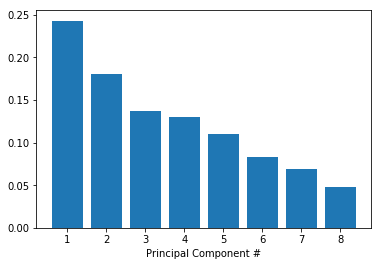

In [14]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(1,len(exp_variance)+1), exp_variance)
ax.set_xlabel('Principal Component #');

## 5. Further visualization of PCA
<p>Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method. </p>
<p>But all is not lost! Instead, we can also look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 90% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

Import `numpy` as `np`. Then use `np.cumsum` on `exp_variance`.

In [15]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

Execute the following code.

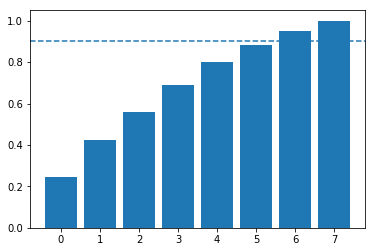

In [16]:
# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
#ax.bar(range(1,len(exp_variance)+1),cum_exp_variance)
ax.bar(range(len(exp_variance)),cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 7

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## 6. Train a decision tree to classify genre
<p>Now we can use the lower dimensional PCA projection of the data to classify songs into genres. To do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.</p>
<p>Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.</p>
<p>Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

We will import `train_test_split` and `DecisionTreeClassifier` from `sklearn`.

In [17]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Split the data, we give the `train_test_splits` function the predictors and and labels and it will generate training and testing datasets. The default is that 25% of the data goes into the testing set.

In [18]:
# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels,random_state=2020)

print("The training data has {} observations".format(train_features.shape[0]))
print("The original data has {} observations".format(pca_projection.shape[0]))

The training data has 3601 observations
The original data has 4802 observations


Next we will train a simple [tree classifier](https://scikit-learn.org/stable/modules/tree.html). Execute the code. This code builds a tree on the training data and then predicts the values for the testing data. We do this to prevent the model from learning all the labels in the training process. Note that we have used the default options to train the model. In practice we would want to optimize these.

In [19]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

Let's see the accuracy of the predictions on the testing data.

In [20]:
tree.score(test_features,test_labels)

0.8667776852622814

This means that with this simple model, we accurately predicted the genre of 86.7% of the songs in the testing data. Is this good?

## 7. Compare our decision tree to a logistic regression and nearest neighbors
<p>Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.</p>
<p>Sometimes simplest is best, and so we will start by applying <strong>logistic regression</strong>. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified). </p>

Import `Logistic Regression` from `sklearn.linear_model`.

In [21]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

Next we will fit a model to the training data.

In [23]:
# Train our logistic regression by fitting training features to training labels and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit( train_features , train_labels )
pred_labels_logit = logreg.predict(test_features)

Let's measure accuracy again.

In [24]:
logreg.score(test_features,test_labels)

0.8967527060782681

This is better but as in our project for the course, let's use more metrics to evaluate our models.

In [25]:
# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.66      0.69      0.67       239
       Rock       0.92      0.91      0.92       962

avg / total       0.87      0.87      0.87      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.82      0.62      0.70       239
       Rock       0.91      0.97      0.94       962

avg / total       0.89      0.90      0.89      1201



Let's repeat for nearest neighbors, but we will `scikit-learn` instead of writing our own code.

In [26]:
# Import the model
from sklearn.neighbors import KNeighborsClassifier

# Train our k-nearest neighbor model and predict labels for the test set
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features,train_labels)
pred_labels_knn = knn.predict(test_features)

In [27]:
knn.score(test_features, test_labels)

0.9125728559533722

Repeat the code above to compare nearest neighbors with the other two models.

In [28]:
class_rep_knn = classification_report(test_labels,pred_labels_knn)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("Nearest Neighbors: \n", class_rep_knn)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.66      0.69      0.67       239
       Rock       0.92      0.91      0.92       962

avg / total       0.87      0.87      0.87      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.82      0.62      0.70       239
       Rock       0.91      0.97      0.94       962

avg / total       0.89      0.90      0.89      1201

Nearest Neighbors: 
              precision    recall  f1-score   support

    Hip-Hop       0.80      0.74      0.77       239
       Rock       0.94      0.95      0.95       962

avg / total       0.91      0.91      0.91      1201



## 8. Balance our data for greater performance
<p>Our models do similarly well, with the nearest neighbors having the superior performance. Looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. </p>
<p>Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>
<p>To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [29]:
echo_tracks["genre_top"].value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

In [30]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks[echo_tracks.genre_top == "Hip-Hop"]
rock_only = echo_tracks[echo_tracks.genre_top == "Rock"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0],random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels, random_state=10)

## 9. Does balancing our dataset improve model bias?
<p>We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance. </p>
<p>Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.</p>

In [32]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Train our nearest neighbor on the balanced data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features,train_labels)
pred_labels_knn = knn.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))
print("Nearest Neighbors: \n", classification_report(test_labels,pred_labels_knn))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.79      0.80      0.79       230
       Rock       0.79      0.78      0.79       225

avg / total       0.79      0.79      0.79       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.88      0.83      0.86       230
       Rock       0.84      0.89      0.86       225

avg / total       0.86      0.86      0.86       455

Nearest Neighbors: 
              precision    recall  f1-score   support

    Hip-Hop       0.89      0.83      0.86       230
       Rock       0.84      0.90      0.87       225

avg / total       0.87      0.86      0.86       455



## 10. Using cross-validation to evaluate our models
<p>Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called <strong>cross-validation</strong> (CV). This step allows us to compare models in a more rigorous fashion.</p>
<p>Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as <strong>K-fold</strong> CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.</p>

In [33]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(5,random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)
knn = KNeighborsClassifier(n_neighbors=3)

# Train our models using KFold cv
tree_score = cross_val_score(tree,pca_projection,labels)
logit_score = cross_val_score(logreg,pca_projection,labels)
knn_score = cross_val_score(knn,pca_projection,labels)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score), "knn:",np.mean(knn_score))

Decision Tree: 0.8208811012680215 Logistic Regression: 0.8522070957095709 knn: 0.8582486538127497


### Congratulations.  

You have just completed a simple machine learning project. The results indicate that logistic regression and nearest neighbors have similar performance in predicting song genre. Note that we have performed little to no model tuning. This will be for Math 378.